In [0]:
import numpy as np
import torch
import torchvision
import pickle


import matplotlib.pyplot  as plt
%matplotlib inline

### Colab link
https://colab.research.google.com/drive/1ZOVjs7ubBTnVBxoVEMXbNC7N21LAY2Cs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with open('drive/My Drive/Colab Notebooks/colored-mnist.pkl', 'rb') as f:
    data = pickle.load(f)

In [0]:
train = data['train']
test = data['test']

In [5]:
print("Count train samples: ", train.shape[0])
print("Count test samples: ", test.shape[0])
print("Shape of image (H, W, C): ", train[0].shape)

Count train samples:  60000
Count test samples:  10000
Shape of image (H, W, C):  (28, 28, 3)


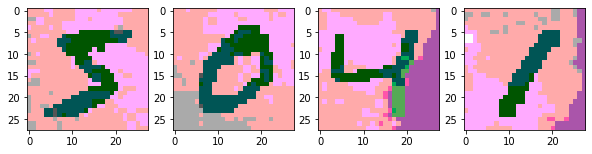

In [6]:
fig = plt.figure(figsize=(10, 10))
def show_image(i, image): 
  print_image =  image * (255 / 3)
  fig.add_subplot(1, 4, i+1)
  plt.imshow(print_image.astype(int))
  

for i in range(0, 4):
  show_image(i, train[i])
plt.show()

In [0]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, target, transform=None):
      self.target = torch.from_numpy(target).view(-1, 3, 28, 28)
      self.transform = transform
      
  def __getitem__(self, index):
      y = self.target[index]
      
      if self.transform:
          y = self.transform(y)
          
      return y
  
  def __len__(self):
      return len(self.target)

In [0]:
BATCHSIZE = 100

In [0]:
train_ds = MyDataset(train)
test_ds = MyDataset(test)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCHSIZE)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCHSIZE)

In [10]:
dataiter = iter(trainloader)
labels = dataiter.next()
print("Tensor shape: ", labels.shape)

Tensor shape:  torch.Size([100, 3, 28, 28])


## Masking

- ConvLayer 7x7 needs Mask A

- The Convlayers in the residual Blocks need the Mask B 


### Example for 3x3 Filter
- Mask A:
$\left( \begin{array}{rrr}
1 & 1 & 1 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
\end{array}\right) $

- Mask B:
$\left( \begin{array}{rrr}
1 & 1 & 1 \\
1 & 1 & 0 \\
0 & 0 & 0 \\
\end{array}\right) $

In [0]:
# Quelle: https://www.codeproject.com/Articles/5061271/PixelCNN-in-Autoregressive-Models
class MaskedConv2d(torch.nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super().__init__(*args, **kwargs)
    assert mask_type in ('A', 'B')
    self.register_buffer('mask', self.weight.data.clone())
    _, _, fH, fW = self.weight.size()
    
    self.mask.fill_(1)
    if (mask_type == 'B'): 
      self.mask[:, :, fH // 2, fW // 2 + 1:] = 0
    else:
      self.mask[:, :, fH // 2, fW // 2:] = 0
    
    self.mask[:, :, fH // 2 + 1:] = 0

  def forward(self, x):
    self.weight.data *= self.mask
    return super(MaskedConv2d, self).forward(x)

In [0]:
class ResBlock(torch.nn.Module):

  def __init__(self, channels=128):
    super(ResBlock, self).__init__()
    self.channels=channels

    self.network = torch.nn.Sequential(
        torch.nn.ReLU(),
        torch.nn.Conv2d(self.channels*2,self.channels, 1, stride=1, padding=0), 
        torch.nn.BatchNorm2d(self.channels), 
        torch.nn.ReLU(),
        MaskedConv2d('B',self.channels, self.channels, 3, stride=1, padding=1),
        torch.nn.BatchNorm2d(self.channels), 
        torch.nn.ReLU(),
        torch.nn.Conv2d(self.channels,self.channels*2, 1, stride=1, padding=0),
        torch.nn.BatchNorm2d(2*self.channels)
      )
    
  def forward(self, x):
    out= self.network(x)
    return x + out


In [0]:
class PixelCNN(torch.nn.Module):
    
  def __init__(self, channels=128, res_blocks=12): 
    super(PixelCNN,self).__init__()
    layers = []
    layers.append(MaskedConv2d("A", 3, channels*2, 7, padding=3))

    for i in range(res_blocks):
      layers.append(ResBlock(channels))

    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Conv2d(channels*2, 1024, 1, 1, 0))
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Conv2d(1024, 3*4, 1, 1, 0))

    self.network = torch.nn.Sequential(*layers)
   
  def forward(self, x):
    out = self.network(x)
    return out.view(-1,4,3,28,28)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
pixelCNN = PixelCNN(128).to(device)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  pixelCNN = torch.nn.DataParallel(pixelCNN)

In [16]:
device

device(type='cuda', index=0)

In [17]:
torch.cuda.device_count()

1

In [0]:
optimizer = torch.optim.Adam(pixelCNN.parameters(),lr=3e-4, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [0]:
def sample_image(batch_size=1):
  image = torch.Tensor(np.random.choice(4, size=(batch_size, 3, 28, 28))).type(torch.FloatTensor).cuda()
  
  for k in range(3): 
    for i in range(28):
      for j in range(28):
        out = pixelCNN(image).permute(0, 4, 3, 2, 1)
        probs = torch.argmax(out, dim=-1).permute(0,3,1,2)
        image[:, k, i, j] = probs[:, k, i, j]
  

  image = image.permute(0,2,3,1).cpu().detach().numpy().astype(int)  
  image = image * (255 / 3)

  if batch_size==1:
    image = image.reshape(28,28,3)
    plt.imshow(image.astype(int), cmap='gray')
    plt.show()
  else:
    fig, axs = plt.subplots(10, 5, figsize=(20, 50))
    count = 0

    for i in range(5):
      for j in range(10):
        temp_image = image[count,:,:,:].astype(int)
        count += 1
        axs[j][i].imshow(temp_image.reshape(28,28,3))

    plt.show()
  return image

epoch: 0 i: 49 loss: 0.28282132744789124 val loss: 0.29359328746795654
epoch: 0 i: 99 loss: 0.23857849836349487 val loss: 0.23511433601379395
epoch: 0 i: 149 loss: 0.19883497059345245 val loss: 0.21759763360023499
epoch: 0 i: 199 loss: 0.2055860161781311 val loss: 0.20921489596366882
epoch: 0 i: 249 loss: 0.18868200480937958 val loss: 0.19755171239376068
epoch: 0 i: 299 loss: 0.18460915982723236 val loss: 0.19188830256462097
epoch: 0 i: 349 loss: 0.17858801782131195 val loss: 0.18631583452224731
epoch: 0 i: 399 loss: 0.17892752587795258 val loss: 0.17557089030742645
epoch: 0 i: 449 loss: 0.16583730280399323 val loss: 0.1696135252714157
epoch: 0 i: 499 loss: 0.16100643575191498 val loss: 0.16353067755699158
epoch: 0 i: 549 loss: 0.15911997854709625 val loss: 0.15649543702602386
epoch: 0 i: 599 loss: 0.15756767988204956 val loss: 0.15831586718559265


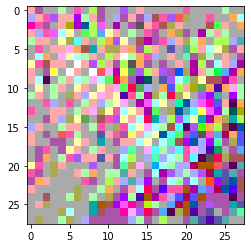

In [20]:
pixelCNN.train(True)
EPOCH = 30
train_loss = []
val_loss = []
j = 0
for epoch in range(EPOCH):
  pixelCNN.train()
  for i, labels in enumerate(trainloader, 0):
    labels = labels.to(device)
    # print("Labels:", labels.shape)
   
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = pixelCNN(labels.float())
    # print("Outout:", outputs.shape)
    loss = criterion(outputs, labels.long())
    
    loss.backward()
    optimizer.step()

    loss = loss.item()
    # print statistics
    j += 1 
    if ((i+1) % 50 == 0):
      with torch.set_grad_enabled(False):
        val_batch = next(iter(testloader))
        val_batch = val_batch.to(device)

        val_output = pixelCNN(val_batch.float())
        val_loss_item = criterion(val_output, val_batch.long()).item()
        val_loss.append(val_loss_item)
      print("epoch:", epoch, "i:" , i, "loss:", loss, "val loss:", val_loss_item)
    train_loss.append(loss)
  sample_image()

Train loss: 


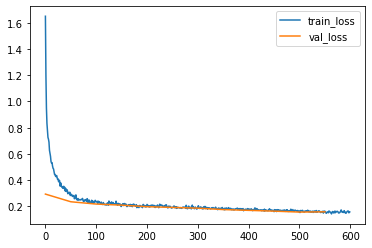

In [21]:
print("Train loss: ")
plt.plot(train_loss, label = "train_loss")
plt.plot(np.arange(0, len(train_loss),int(len(train_loss)/len(val_loss))),val_loss, label = "val_loss")
plt.legend()
plt.show()


In [0]:
# save
torch.save(pixelCNN.state_dict(), 'drive/My Drive/Colab Notebooks/pixel_cnn_model')

In [23]:
# load
pixelCNN = PixelCNN().to(device)
pixelCNN.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/pixel_cnn_model'))

<All keys matched successfully>

### 1b

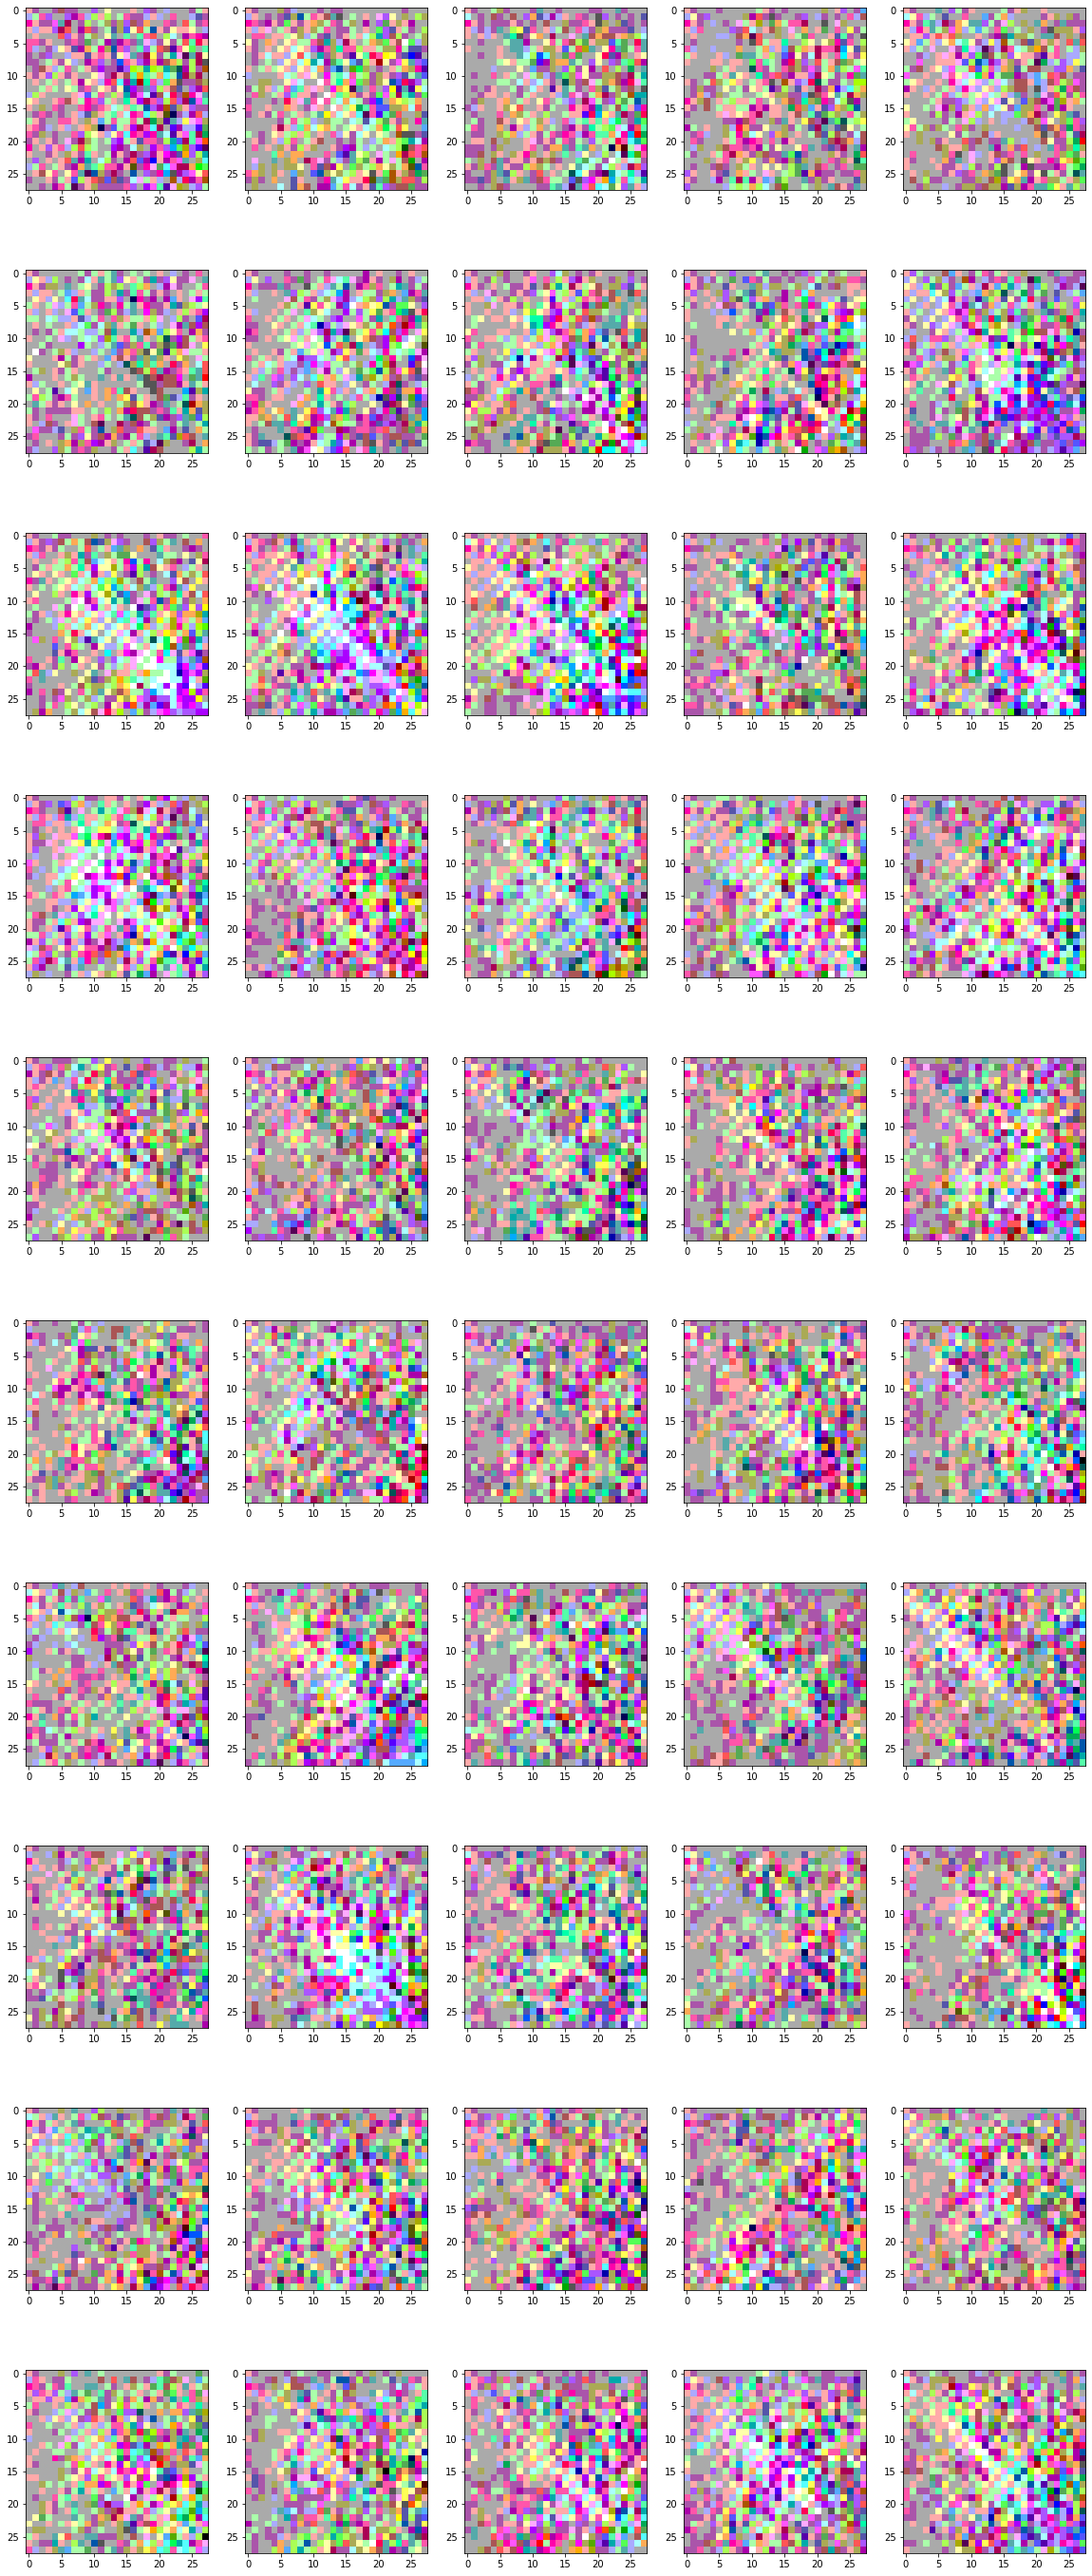

In [24]:
images = sample_image(100)

In [0]:
# Saving images
torchvision.utils.save_image(torch.from_numpy(images).permute(0,3,1,2), 'drive/My Drive/Colab Notebooks/sample.png', nrow=10, padding=0)

### 1c
trying to get the gradient. but it's None...

In [30]:
criterion = torch.nn.CrossEntropyLoss()

image = torch.autograd.Variable(torch.Tensor(np.random.choice(4, size=(1, 3, 28, 28))), requires_grad=True).cuda()
out = pixelCNN(image)
pixel_distribution = out[0,:,:,14,14]

target = image[0,:,14,14]
loss = criterion(pixel_distribution.permute(1,0), target.long())
loss.backward()

grads = image.grad.data[0].permute(1,2,0).detach().numpy()
max_grad = np.amax(np.absolute(grads), axis=2)
plt.imshow(max_grad, cmap='gray')

AttributeError: ignored